### Environment Setup

In [188]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [189]:
from dotenv import load_dotenv
_ = load_dotenv()

In the Basics notebook, we created templates and invoked them and finally feed the result to the LLM. We can make this easier by using Langchain expression language (LCEL) which is very similar to the piping in the Linux shells.

In [190]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [191]:
out = llm.invoke("Hello, who are you?")
print(out.content)

Hello! I’m an AI language model created by OpenAI. I'm here to assist you with information, answer questions, and engage in conversation. How can I help you today?


### Basic Graph

#### Defining

Langgraph allows to define a flow of operations. There can be decision points in it. We'll start with a simple graph.

In [192]:
from langgraph.graph import Graph, END

# define two functions that'll be executed in the graph nodes.
# adds "Hi" to the input, and returns the result
def function_1(input_1):
    return input_1 + " Hi "

# adds "there" to the output of previous node, and returns the result
def function_2(input_2):
    return input_2 + "there"

In [193]:
# define the Langchain graph
graph = Graph()

# define nodes independent of order
graph.add_node("node_1", function_1)
graph.add_node("node_2", function_2)

# connect nodes using edges
graph.add_edge('node_1', 'node_2')

# define entry exit
graph.set_entry_point("node_1")
graph.set_finish_point("node_2")
# or graph.add_edge('node_2', END)

cg = graph.compile()

In [194]:
# visualize the graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

def visualize_langgraph(g):
    display(
        Image(
            g.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )

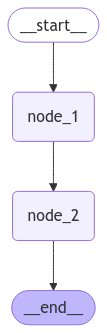

In [195]:
visualize_langgraph(cg)

#### Executing

We can run the graph using invoke or node-by-node streaming

In [196]:
# invoke the graph
cg.invoke("Hello")

'Hello Hi there'

In [197]:
# node by node processing
input = 'Hello'
for output in cg.stream(input):
    print(f"Streaming {output}")
    # stream() yields dictionaries with output keyed by node name

Streaming {'node_1': 'Hello Hi '}
Streaming {'node_2': 'Hello Hi there'}


### Adding Decisions

Our simple graph does not hold any state, and it doesn't have any decision points. Now we'll build a graph with state and decision points.
This graph will process user input and classify it as greeting or question. Depending on the classification, it will respond with a greeting or handle the search.

In [198]:
from typing import Dict, TypedDict, Optional

# this is the structure of state that'll be maintained during the graph flow.
# each graph will start with an empty state(dict), and this dictionary will be populated by the return values of each node.
# langgraph handles this state management internally.

class State(TypedDict):
  question: str
  classification: str
  response: str
  dummy: Optional[str] = None # just to show that optional fields, and initial values are supported.

In [199]:
from langgraph.graph import StateGraph,  END

# define the functions that'll be executed in the graph nodes.
def handle_greeting(state):
    return {"response": "Hello! How can I help you today?"}

def handle_search(state):
    question = state.get('question', '').strip()
    search_result = f"Search result for '{question}'"
    return {"response": search_result}

def classify_input(state):
    question = state.get('question', '').strip()
    if "hello" in question.lower():
      classification = "greeting"
    else:
      classification = "search"
    return {"classification": classification}

def decide_next(state):
    return state.get('classification')

In [200]:
# define the Langchain graph
graph = StateGraph(State)

# the user input goes first to classify_input_node.
graph.add_node("classify_input_node", classify_input)
graph.add_node("greeting_node", handle_greeting)
graph.add_node("search_node", handle_search)

# if it's classified as greeting, it goes to greeting_node, else to search_node
graph.add_conditional_edges(
    "classify_input_node",
    decide_next,
    {
        "greeting": "greeting_node",
        "search": "search_node"
    }
)
# when there are multiple ends, they are set as below
graph.set_entry_point("classify_input_node")
graph.add_edge("greeting_node", END)
graph.add_edge("search_node", END)

cg = graph.compile()

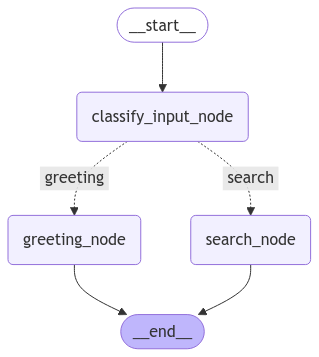

In [201]:
# visualize the graph
visualize_langgraph(cg)

In [202]:
# as the first node expects a question in the state dictionary, we'll pass it as a dictionary
cg.invoke({"question": "Hello, how are you?"})

{'question': 'Hello, how are you?',
 'classification': 'greeting',
 'response': 'Hello! How can I help you today?'}

In [203]:
cg.invoke({"question": "Who is Barack Obama?"})

{'question': 'Who is Barack Obama?',
 'classification': 'search',
 'response': "Search result for 'Who is Barack Obama?'"}

### Adding an LLM

Now we'll create a graph with LLM and tools.

In [204]:
from langchain_openai import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

# Set the model as ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [205]:
from langchain_core.tools import tool

@tool
def multiply(x: float, y: float) -> float:
    """Multiply 'x' times 'y'."""
    return x * y


@tool
def exponentiate(x: float, y: float) -> float:
    """Raise 'x' to the 'y'."""
    return x**y


@tool
def add(x: float, y: float) -> float:
    """Add 'x' and 'y'."""
    return x + y

tools = [multiply, exponentiate, add]
llm_with_tools = llm.bind_tools(tools)

In [206]:
from typing import Annotated, List, TypedDict
from langgraph.graph import add_messages

# we create a more special state here. As expected it'll have a messages field.
# But this field has a special annotation, add_messages, which tells langgraph to append the messages to this list using add_messages function.
# which creates a HumanMessage object if the input is a string, and appends it to the list.
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [207]:
def call_model(state):
    return {"messages": llm_with_tools.invoke(state["messages"])}

In [208]:
graph = StateGraph(AgentState)

graph.add_node("agent", call_model)
graph.add_edge("agent", END)
graph.set_entry_point("agent"
                      )
cg = graph.compile()

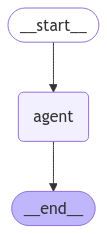

In [209]:
visualize_langgraph(cg)

In [210]:
out = cg.invoke({"messages": "what's 3 plus 6"})

In [211]:
out['messages']

[HumanMessage(content="what's 3 plus 6", additional_kwargs={}, response_metadata={}, id='daae4cb6-2d9b-451f-a5d8-bb4678e922c7'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nU6QQ8h1H4MI1wsoyJYHwy9U', 'function': {'arguments': '{"x":3,"y":6}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 107, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-122d0471-090e-4e00-b902-88dc8978eec6-0', tool_calls=[{'name': 'add', 'args': {'x': 3, 'y': 6}, 'id': 'call_nU6QQ8h1H4MI1wsoyJYHwy9U', 'type': 'tool_call'}], usage_metadata={'input_tokens': 107, 'output_tokens': 18, 'total_tokens'

In [212]:
out['messages'][-1].tool_calls

[{'name': 'add',
  'args': {'x': 3, 'y': 6},
  'id': 'call_nU6QQ8h1H4MI1wsoyJYHwy9U',
  'type': 'tool_call'}]

### Adding Tool call

We'll add the tool call and it's result. There are multiple ways to do it.

#### Manual

We'll manually find the tool and invoke it

In [213]:
# create a mapping from tool name to tool object
tool_mapping = {tool.name: tool for tool in tools}

In [214]:
from langchain_core.messages import ToolMessage

def call_tool_manual(state):
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call['name']]
    # invoke of the tool automatically handles the tool call dictionary
    return {"messages": tool.invoke(tool_call)}

In [215]:
# define the Langchain graph
graph = StateGraph(AgentState)

graph.add_node("llm_node", call_model)
graph.add_node("tool_node", call_tool_manual)
graph.add_edge("llm_node", "tool_node")
graph.add_edge("tool_node", END)
graph.set_entry_point("llm_node")

cg = graph.compile()

In [216]:
out = cg.invoke({"messages": "what's 3 plus 6"})

In [217]:
out['messages']

[HumanMessage(content="what's 3 plus 6", additional_kwargs={}, response_metadata={}, id='f0817e09-7810-4600-97e5-e1d60119373b'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YqraV3Aw2EKKkRcXbKMmdT5A', 'function': {'arguments': '{"x":3,"y":6}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 107, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0c0a0921-534b-4037-81f2-f6cb3223f937-0', tool_calls=[{'name': 'add', 'args': {'x': 3, 'y': 6}, 'id': 'call_YqraV3Aw2EKKkRcXbKMmdT5A', 'type': 'tool_call'}], usage_metadata={'input_tokens': 107, 'output_tokens': 18, 'total_tokens'

#### ToolNode

ToolNode is a node that can be used to invoke a tool. We'll use it to invoke the tool. No need to implement a function for tool calling.

In [218]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

In [219]:
# define the Langchain graph
graph = StateGraph(AgentState)

graph.add_node("llm_node", call_model)
graph.add_node("tool_node", tool_node)
graph.add_edge("llm_node", "tool_node")
graph.add_edge("tool_node", END)
graph.set_entry_point("llm_node")

cg = graph.compile()

In [220]:
out = cg.invoke({"messages": "what's 3 plus 6"})

In [221]:
out['messages']

[HumanMessage(content="what's 3 plus 6", additional_kwargs={}, response_metadata={}, id='c7d2866b-be9a-411e-94f4-7fd0bb13089b'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CVno4OkxIFeewWXzUJgC2h88', 'function': {'arguments': '{"x":3,"y":6}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 107, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-811e1ba2-4cf4-4ce4-9f51-2c47b8dac0c8-0', tool_calls=[{'name': 'add', 'args': {'x': 3, 'y': 6}, 'id': 'call_CVno4OkxIFeewWXzUJgC2h88', 'type': 'tool_call'}], usage_metadata={'input_tokens': 107, 'output_tokens': 18, 'total_tokens'

#### Evaluating Result

LLM now need to interpret the tool call result. We'll add a node to evaluate the result.

In [222]:
# define the Langchain graph
graph = StateGraph(AgentState)

graph.add_node("llm_node", call_model)
graph.add_node("tool_node", tool_node)
graph.add_node("final_node", call_model)

graph.add_edge("llm_node", "tool_node")
graph.add_edge("tool_node", "final_node")
graph.add_edge("final_node", END)
graph.set_entry_point("llm_node")

cg = graph.compile()

In [223]:
out = cg.invoke({"messages": "what's 3 plus 6"})

In [224]:
out['messages'][-1].content

'3 plus 6 equals 9.'

### Adding loop

Above instead of adding same LLM node multiple times, we can use a loop to repeat the same node multiple times.

In [225]:
def visit_tool(state):
    return "yes" if state["messages"][-1].tool_calls else "no"

In [226]:
graph = StateGraph(AgentState)
graph.add_node("llm_node", call_model)
graph.add_node("tool_node", tool_node)
graph.add_conditional_edges(
    "llm_node",
    visit_tool,
    {
        "yes": "tool_node",
        "no": END,
    },
)
graph.add_edge("tool_node", "llm_node")
graph.set_entry_point("llm_node")
cg = graph.compile()

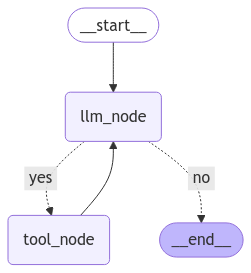

In [227]:
visualize_langgraph(cg)

In [228]:
out = cg.invoke({"messages": "what's 3 plus 6"})

In [229]:
out['messages'][-1].content

'3 plus 6 equals 9.'

### Streaming

Previously we only streamed the graph node processing.We need to filter only LLM message content (not tool nodes, not tool call messages etc...)

In [230]:
# filtered node streaming
for output in cg.stream({"messages": "what's 3 plus 6"}):
    for k,v in output.items():
        # check if this is from llm_node and message has content (not tool call etc)
        if k=='llm_node' and v['messages'].content:
            print(v['messages'].content)

3 plus 6 equals 9.


Token streaming is still posibble, but only with async functions.

In [231]:
# token streaming
async for e in cg.astream_events({"messages": "what's 3 plus 6"}, version="v1"):
    if e["event"] == "on_chat_model_stream":
        print(e['data']['chunk'].content,end="")

3 plus 6 equals 9.